<a href="https://colab.research.google.com/github/Mateusz-best-creator/CelebritiesRecognition/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cpu


## Loading Data

In [45]:
import os

dataset_path = "/content/drive/MyDrive/celebrities_images"
count = 0
for root, dirs, files in os.walk(dataset_path):
  print(f"There are {len(dirs)} directories, {len(files)} image files in {root}")
  count += 1
  if count >= 10:
    break

There are 98 directories, 0 image files in /content/drive/MyDrive/celebrities_images
There are 0 directories, 50 image files in /content/drive/MyDrive/celebrities_images/Vin Diesel
There are 0 directories, 187 image files in /content/drive/MyDrive/celebrities_images/Sushant Singh Rajput
There are 0 directories, 196 image files in /content/drive/MyDrive/celebrities_images/Yami Gautam
There are 0 directories, 33 image files in /content/drive/MyDrive/celebrities_images/Sunny Deol
There are 0 directories, 41 image files in /content/drive/MyDrive/celebrities_images/Suniel Shetty
There are 0 directories, 46 image files in /content/drive/MyDrive/celebrities_images/Sonam Kapoor
There are 0 directories, 82 image files in /content/drive/MyDrive/celebrities_images/Tom Cruise
There are 0 directories, 88 image files in /content/drive/MyDrive/celebrities_images/Tom Holland
There are 0 directories, 81 image files in /content/drive/MyDrive/celebrities_images/Tom Hanks


In [46]:
import requests
from pathlib import Path

# Setup path to a data folder
image_path = Path("/content/drive/MyDrive/celebrities_images")

In [47]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_2.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_17.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_22.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_14.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_21.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_13.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_1.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_19.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_11.jpg'),
 PosixPath('/content/drive/MyDrive/celebrities_images/Vin Diesel/Image_18.jpg')]

Height = 1120 | Width = 747


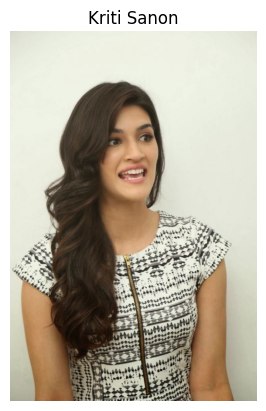

In [48]:
random_path = random.choice(image_path_list)
image_class = random_path.parent.stem
img = Image.open(random_path)

print(f"Height = {img.height} | Width = {img.width}")

plt.imshow(img)
plt.title(image_class)
plt.axis("off")
plt.show()

## Creating data transformations

In [49]:
from torchvision.transforms import v2

IMAGE_SIZE = 224
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

transformed_image = transforms(img)
transformed_image.shape

torch.Size([3, 224, 224])

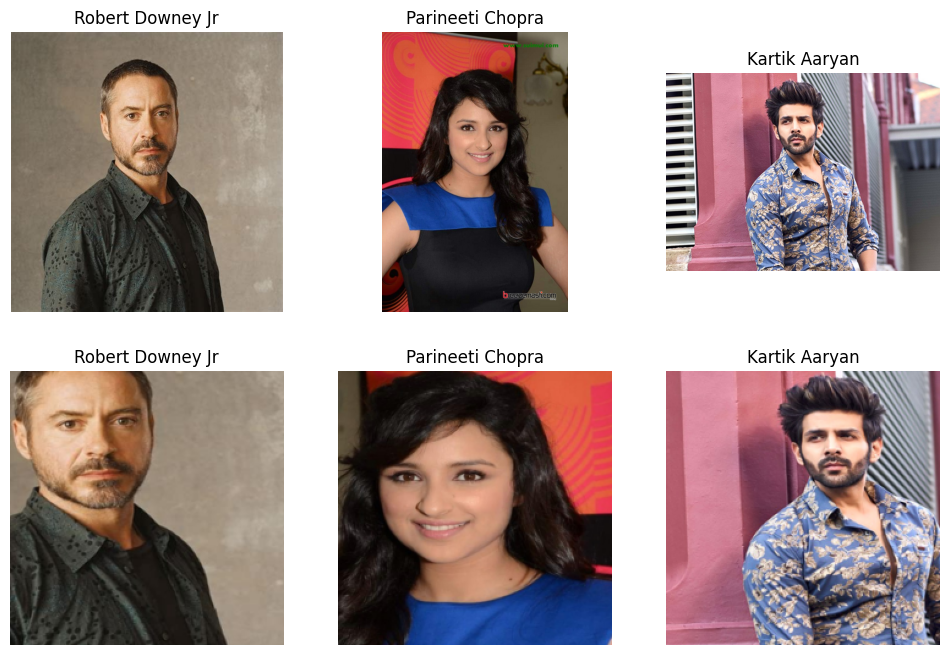

In [50]:
fig, ax = plt.subplots(nrows=2,
                       ncols=3,
                       figsize=(12, 8))

for col in range(3):

  random_path = random.choice(image_path_list)
  image_class = random_path.parent.stem
  img = Image.open(random_path)
  img_transformed = transforms(img).permute(1, 2, 0)

  for row in range(2):

    ax[row, col].set_title(image_class)
    if row == 0:
      ax[row, col].imshow(img)
    else:
      ax[row, col].imshow(img_transformed)
    ax[row, col].axis("off")

plt.show()

## Creating datasets using `ImageFolder`

In [72]:
import torchvision
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader, Subset

dataset = torchvision.datasets.ImageFolder(dataset_path,
                                           transform=transforms)

def get_subset(indices, start, end):
    return indices[start : start + end]


TRAIN_PCT, VALIDATION_PCT = 0.7, 0.15  # rest will go for test
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)
indices = torch.randperm(len(dataset))
train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(dataset))

BATCH_SIZE = 32

class CustomTransformDataset(Dataset):

  def __init__(self,
               subset,
               transform):
    self.subset = subset
    self.transform = transform

  def __len__(self):
    return len(self.subset)

  def __get_item__(self, idx):
    s = self.subset[idx]
    if self.transform:
      s = self.transform(s)
    return s

def create_dataloaders(dataset,
                       batch_size=BATCH_SIZE,
                       train_porportion=0.7,
                       valid_proportion=0.15,
                       test_proportion=0.15,
                       train_valid_transform=None,
                       test_transform=None):

  dataset = torchvision.datasets.ImageFolder(dataset_path)
  # Split indices
  TRAIN_PCT, VALIDATION_PCT = 0.7, 0.15
  total = len(dataset)
  indices = torch.randperm(total).tolist()

  train_end = int(TRAIN_PCT * total)
  val_end = train_end + int(VALIDATION_PCT * total)

  train_indices = indices[:train_end]
  val_indices = indices[train_end:val_end]
  test_indices = indices[val_end:]

  train_subset = Subset(dataset, train_indices)
  val_subset = Subset(dataset, val_indices)
  test_subset = Subset(dataset, test_indices)

  train_dataset = CustomTransformDataset(train_subset, train_valid_transform)
  val_dataset = CustomTransformDataset(val_subset, test_transform)
  test_dataset = CustomTransformDataset(test_subset, test_transform)

  BATCH_SIZE = 32
  return {
      "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
      "validation": DataLoader(val_dataset, batch_size=BATCH_SIZE),
      "test": DataLoader(test_dataset, batch_size=BATCH_SIZE)
  }


dataloaders = create_dataloaders(dataset)
print(f'Lengths: Train = {len(dataloaders["train"])} | Validation = {len(dataloaders["validation"])} | Test = {len(dataloaders["test"])} | Batch Size = {BATCH_SIZE}')
dataloaders

Lengths: Train = 268 | Validation = 58 | Test = 58 | Batch Size = 32


{'train': <torch.utils.data.dataloader.DataLoader at 0x7e62b60c8990>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7e62b6059b90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e62b6059350>}

In [73]:
CLASS_NAMES = dataset.classes
CLASS_NAMES[:10]

['Aamir Khan',
 'Abhay Deol',
 'Abhishek Bachchan',
 'Aishwarya Rai',
 'Ajay Devgn',
 'Akshay Kumar',
 'Akshaya Khanna',
 'Akshaye Khanna',
 'Alia Bhatt',
 'Amitabh Bachchan']

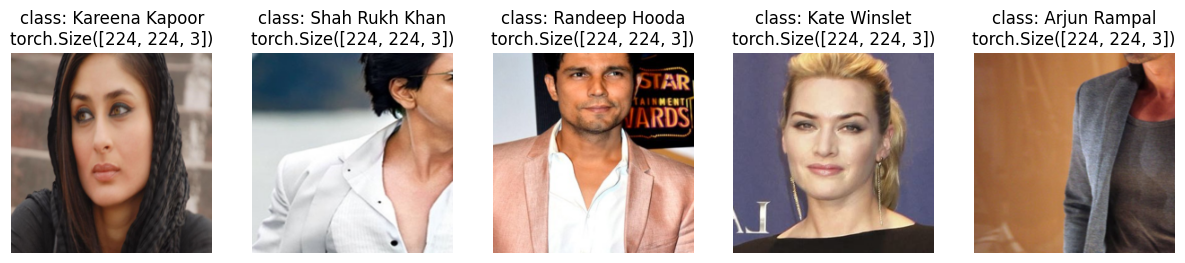

In [74]:
def display_random_images(dataset,
                          classes = None,
                          n = 10,
                          display_shape = True):

    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(15, 5))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\n{targ_image_adjust.shape}"
        plt.title(title)

display_random_images(dataset, CLASS_NAMES, n=5)

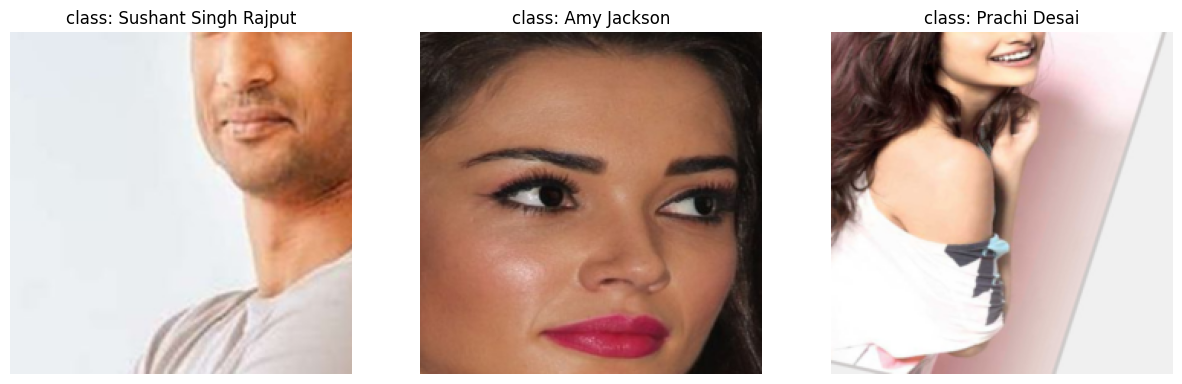

In [75]:
display_random_images(dataset, CLASS_NAMES, n=3, display_shape=False)

## Building TinyVGG model

In [78]:
simple_transform = v2.Compose([v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
                               v2.ToImage(),
                               v2.ToDtype(torch.float32, scale=True)])
dataloaders = create_dataloaders(dataset,
                                 train_valid_transform=simple_transform,
                                 test_transform=simple_transform)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e62b469f490>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7e62b6030050>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e62b469f510>}